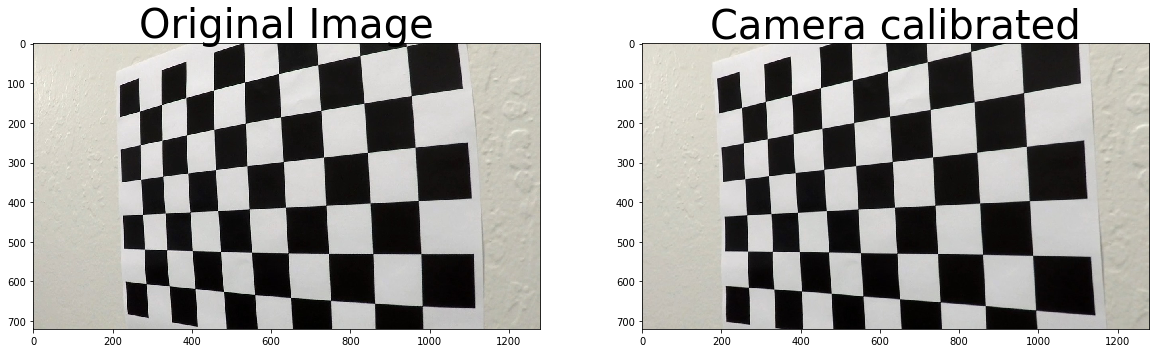

In [1]:
#pipeline for advanced lane finding:

#1.- Camera calibration
#Camera calibration

import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

images = glob.glob("camera_cal/calibration*.jpg")

objpoints = []
imgpoints = []

nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        chess_corn = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
     #2.- undistord image
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # If found, add object points, image points
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undist)
ax2.set_title('Camera calibrated', fontsize=40)

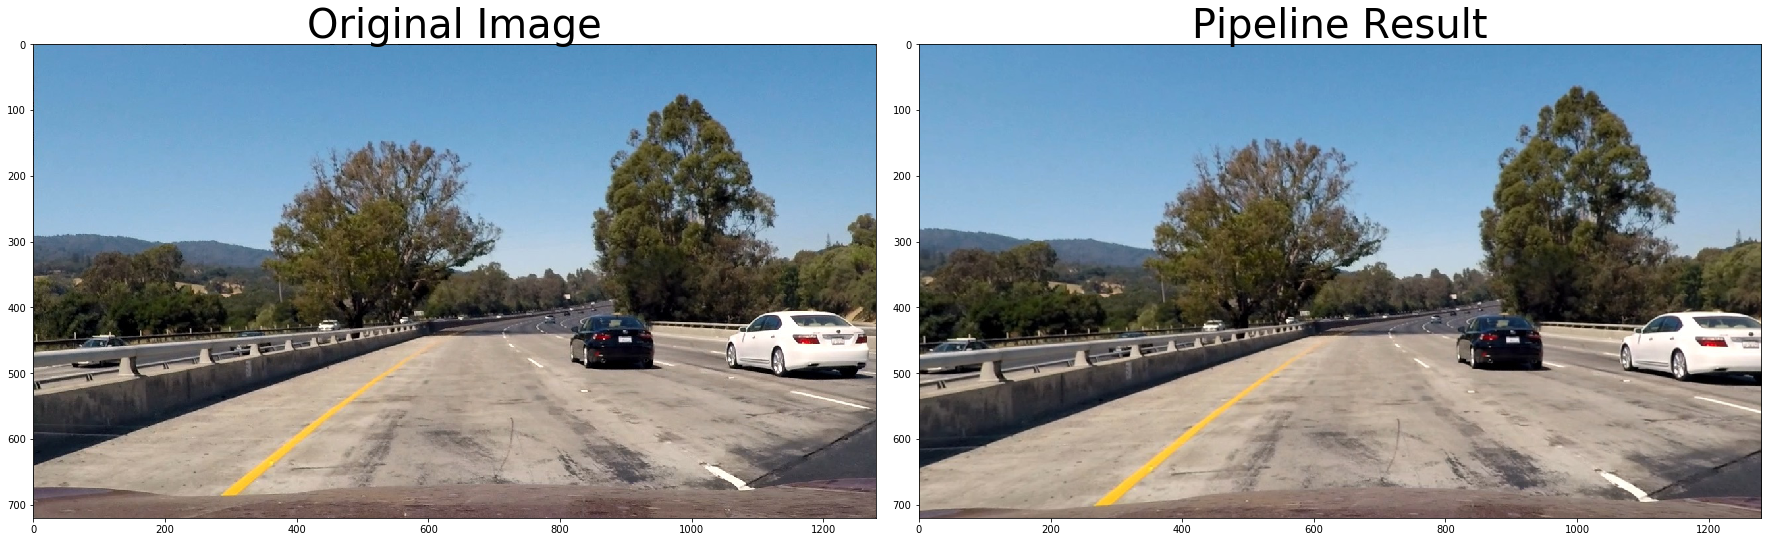

In [2]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Visualize undistortion
fname = 'test_images/test1.jpg'
image = mpimg.imread(fname)
result = cv2.undistort(image, mtx, dist, None, mtx)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
#3.- functions of interest
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def hls_s(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    return s_channel

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F , 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F , 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def paint_lines(img, corners):
    corner_tuples=[]
    for ind,c in enumerate(corners):
        corner_tuples.append(tuple(corners[ind]))
    #cv2.polylines(img, corners, True, (0,255,0,0), 1)
    cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=2)
    cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=2)
    cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=2)
    cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=2)

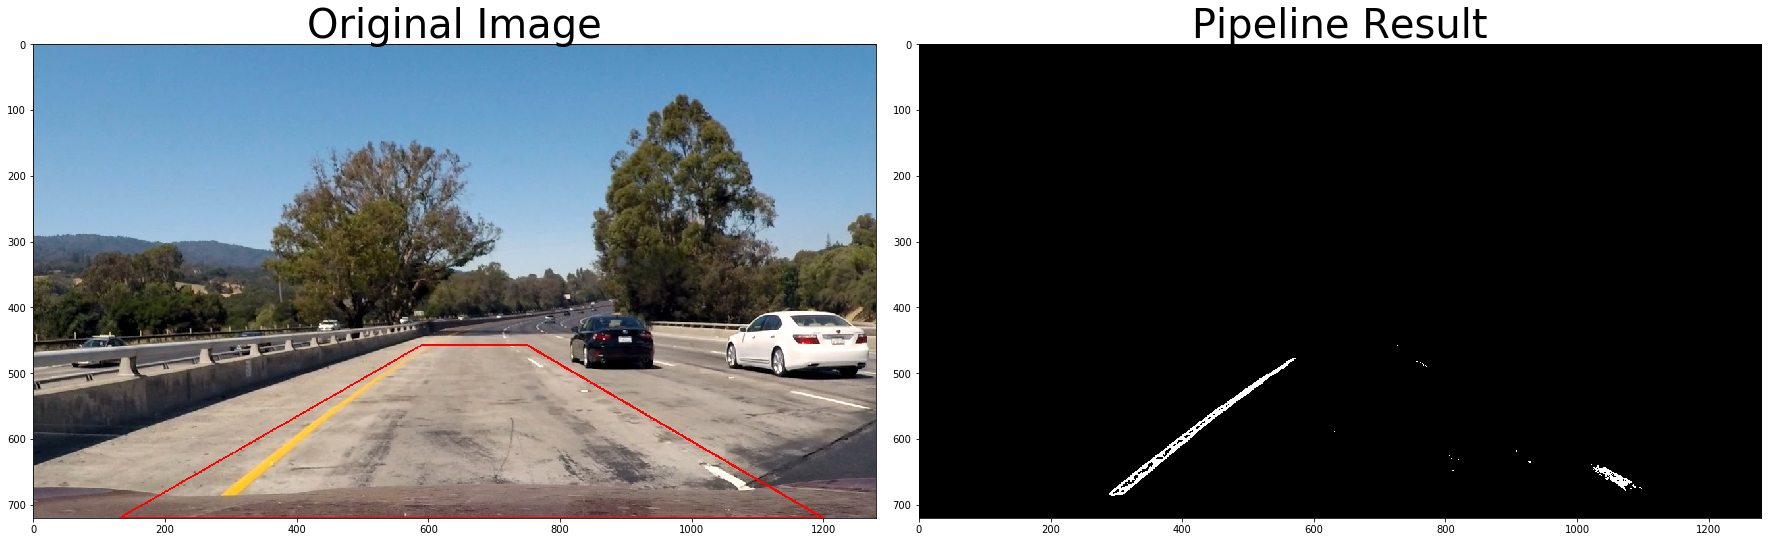

In [5]:
# Pipeline:
def pipeline(img):
    img = gaussian_blur(img, 5)
    s_channel = hls_s(img)
    gray = grayscale(img)
    
    
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(40, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.8, 1.2))
    # Combine all the thresholding
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s_channel > 160) & (s_channel < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    #corners
    corners = np.array([[130,720],[589,457],[750,457],[1200,720]], dtype=np.int32)
    # Masked area
    vertices = np.array([[(130, 720), (589, 457), (750, 457), (1200, 720)]], dtype=np.int32)
    color_binary = region_of_interest(color_binary, vertices)
    paint_lines(image, corners)
    return color_binary

fname = 'test_images/test1.jpg'
image = mpimg.imread(fname)
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

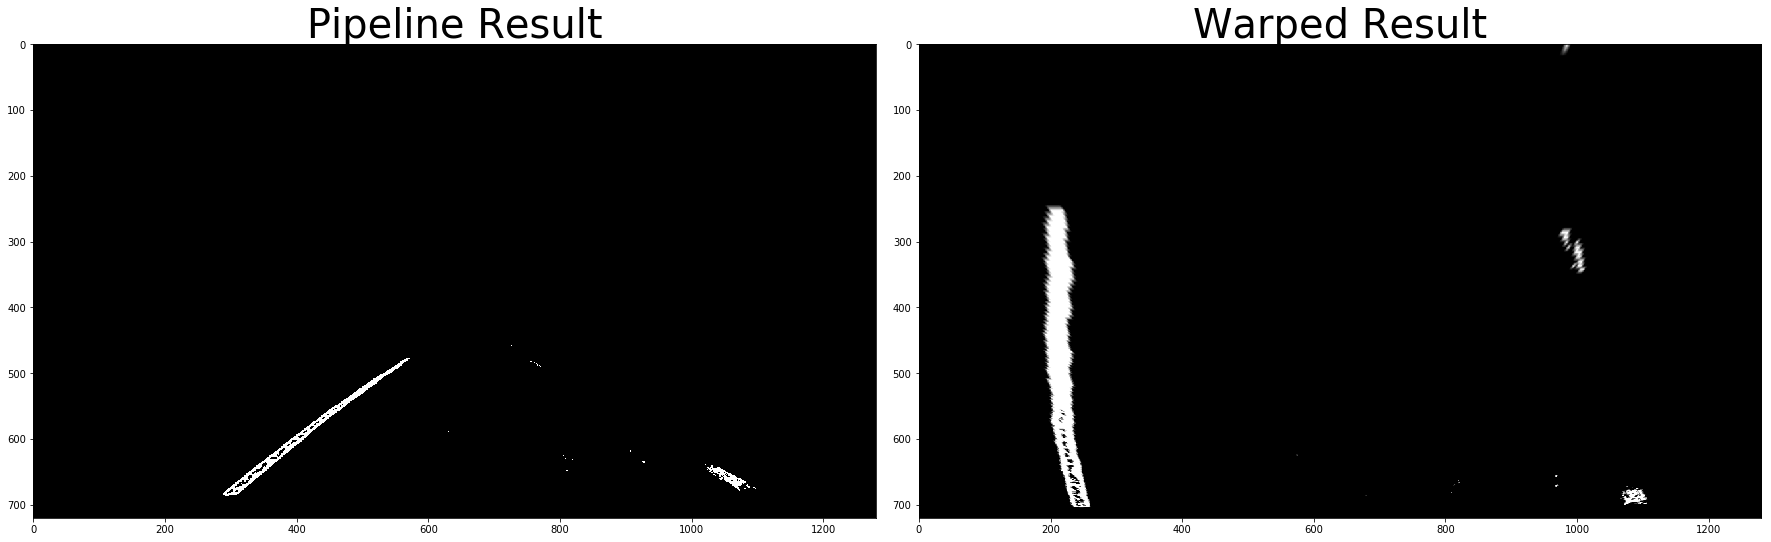

In [6]:
#5.- transform the region of interest
area_of_interest = [[589,457],[750,457],[1200,720],[145,720]]

def corners_unwarp(img, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undistord = cv2.undistort(img, mtx, dist, None, mtx)
    offset = 150
    offset2 = 0
    img_size = (img.shape[1], img.shape[0])
            
    src = np.float32(area_of_interest)
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset, offset2],
                      [img_size[0]-offset, offset2], 
                      [img_size[0]-offset, img_size[1]-offset2], 
                      [offset, img_size[1]-offset2]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #delete the next two lines
    return warped, M, Minv

# Plot the result

fname = 'test_images/test1.jpg'
image = mpimg.imread(fname)
result = pipeline(image)

warped, M, Minv = corners_unwarp(result, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


ax1.imshow(result, cmap='gray')
ax1.set_title('Pipeline Result', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1
        # always the same y-range as image
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2 
        # last value
        self.last_value = None



In [8]:
#TODO sanity check
def sanity_check(line, curvature, fitx, fit):
    if line.detected:
        if (abs(curvature / line.radius_of_curvature -1) < 0.5) and ():
            line.bestx = np.mean(fitx)
            line.current_fit = fit
            line.radius_of_curvature = curvature
            line.allx = fitx
        else:
            if (curvature > line.radius_of_curvature):
                line.detected = False
                fitx = line.allx
    else:
        # If lane was not detected and no curvature is defined
        if line.radius_of_curvature: 
            if abs(curvature / line.radius_of_curvature - 1) < 1:            
                line.detected = True
                line.current_fit = fit
                line.allx = fitx
                line.bestx = np.mean(fitx)            
                line.radius_of_curvature = curvature
                line.current_fit = fit
            else:
                fitx = line.allx      
        # If curvature was defined
        else:
            line.detected = True
            line.current_fit = fit
            line.allx = fitx
            line.bestx = np.mean(fitx)
            line.radius_of_curvature = curvature
    return fitx
    
def distance_sanity_check(left, right, leftx_fit, rightx_fit):
    if left.detected and right.detected:
        print(abs(left.last_value - right.last_value))
    else:
        print(abs(leftx_fitx, rightx_fit))

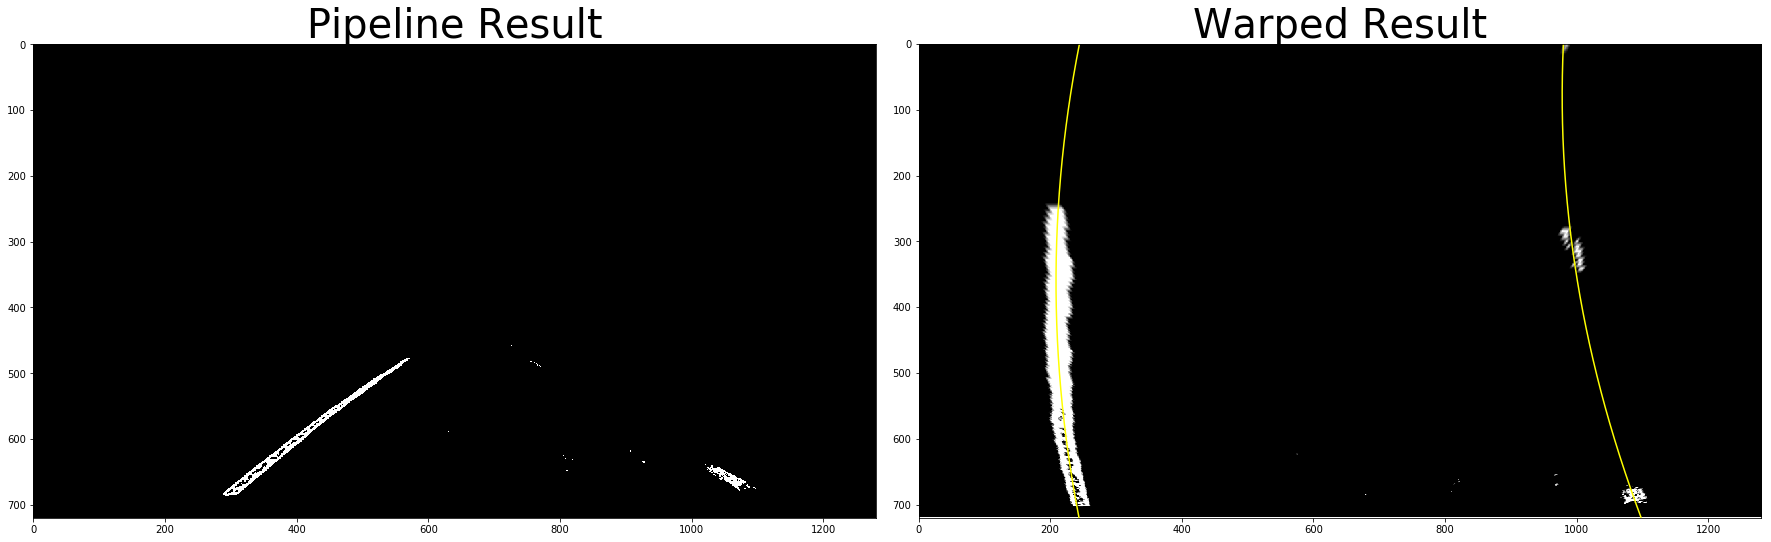

In [9]:
#If lanes not detected:

def find_lanes(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx

def fit_lines(binary_warped, left_fit, right_fit):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
        return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx
    
    

fname = 'test_images/test1.jpg'
image = mpimg.imread(fname)
result = pipeline(image)
warped, M, Minv = corners_unwarp(result, mtx, dist)
left = Line()
right = Line()
left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = find_lanes(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


ax1.imshow(result, cmap='gray')
ax1.set_title('Pipeline Result', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def get_curvature(ploty, leftx, rightx):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def position(img, pts, center_pre):
    initial = img.shape[1]/2
    left_pts = pts[(pts[:,1]<initial)&(pts[:,0]>img.shape[0]-20)][:,1]
    right_pts = pts[(pts[:,1]>initial)&(pts[:,0]>img.shape[0]-20)][:,1]
    if (len(right_pts) == 0):
        center = center_pre
    else:
        left = np.min(left_pts)
        right = np.max(right_pts)
        center = (left+right)/2
    return (initial-center)*xm_per_pix

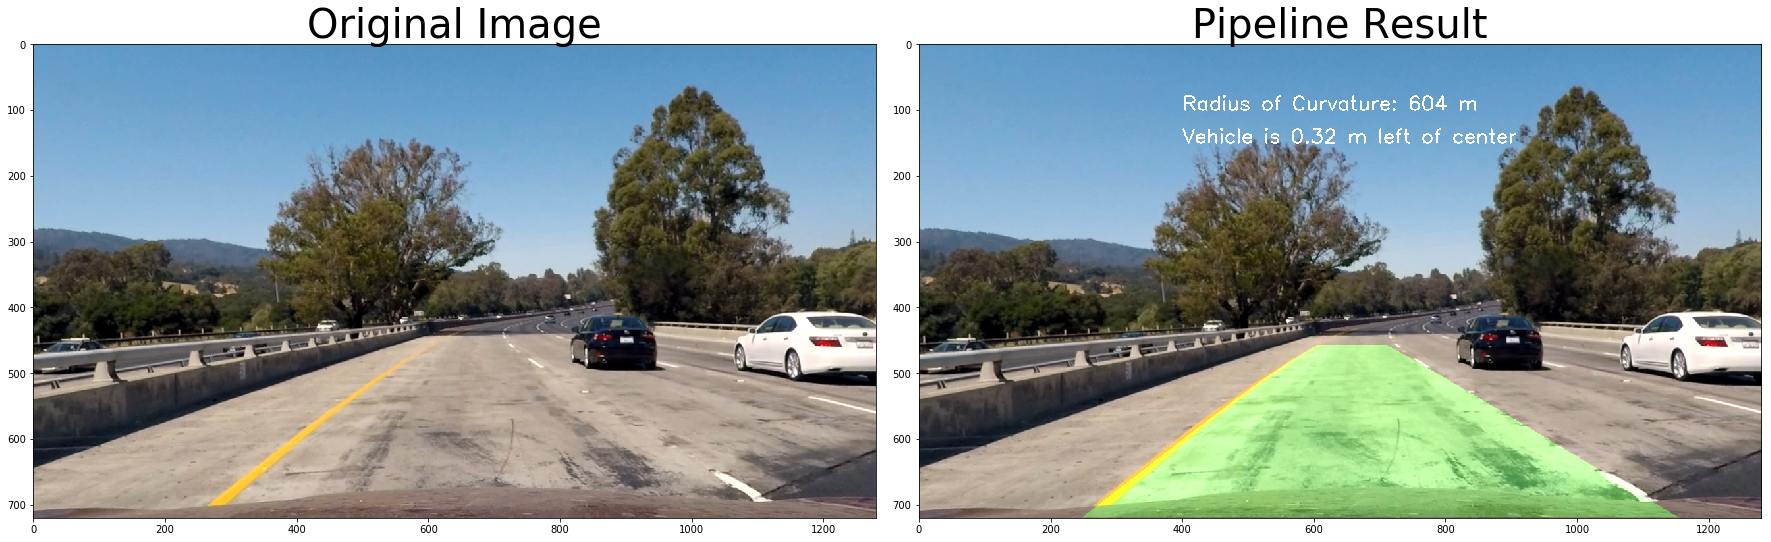

In [11]:
# Create an image to draw the lines on
def draw_lane(warped, left_fitx, right_fitx, ploty, Minv, undist, curvature, car_position):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    pts = np.argwhere(newwarp[:,:,1])
    car_position_pre = car_position
    car_position = position(result,pts, car_position_pre)
    if car_position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-car_position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(car_position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result

#for i in range(1,7):
fname = 'test_images/test1.jpg'
image = mpimg.imread(fname)
undist = cv2.undistort(image, mtx, dist, None, mtx)
result = pipeline(undist)
warped, M, Minv = corners_unwarp(result, mtx, dist)
left  = Line()
right = Line()
left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = find_lanes(warped)
left_curvature, right_curvature = get_curvature(ploty, left_fitx, right_fitx)
car_position = 0
image_fin = draw_lane(warped, left_fitx, right_fitx, ploty, Minv, undist, left_curvature, car_position)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_fin)
ax2.set_title('Pipeline Result', fontsize=40)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:

def def_pipeline(image, left, right, car_position):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = pipeline(undist)
    warped, M, Minv = corners_unwarp(result, mtx, dist)
    if (left.detected == False) and (right.detected ==False):
        left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = find_lanes(warped)
    else:
        left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx = fit_lines(warped, left.current_fit, right.current_fit)
    left_curvature, right_curvature = get_curvature(ploty, left_fitx, right_fitx)
    left_fitx = sanity_check(left, left_curvature, left_fitx, left_fit)
    right_fitx = sanity_check(right,right_curvature, right_fitx, right_fit)
    result = draw_lane(warped, left_fitx, right_fitx, ploty, Minv, undist, left_curvature, car_position)
    
    return result

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left = Line()
right = Line()
left_fit, right_fit = [], []
car_position = 0
def process_image(image):
    image_fin = def_pipeline(image, left,right, car_position)

    return image_fin

In [14]:
white_output = 'project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [05:38<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 15min 44s, sys: 1.85 s, total: 15min 46s
Wall time: 5min 38s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))